In [1]:
import os
import glob
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.acolite import (
    get_acolite_band_tif_paths,
    get_eopatch_for_acolite_band_tif
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_puerto_rico'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 5, 2, 15, 7, 19),
  'D:\\sdb_datasets\\sentinel_puerto_rico\\S2B_MSIL2A_20210502T150719_N9999_R082_T19QFA_20220425T153242.SAFE')]

In [20]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders

['D:\\sdb_datasets\\sentinel_puerto_rico\\S2B_MSI_20210502T150719_ACOLITE_SUBSET']

In [26]:
bathy_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'puerto_rico_bathy_eop')
)
load_bathy_eop = LoadTask(bathy_eop_path)

output_label = 'puerto_rico_bathy_eop'

wf_nodes = linearly_connect_tasks(
    load_bathy_eop,
    OutputTask(output_label),
)
workflow = EOWorkflow(wf_nodes)

workflow_result = workflow.execute()
puerto_rico_bathy_eop = workflow_result.outputs[output_label]

height, width, _ = puerto_rico_bathy_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=puerto_rico_bathy_eop.bbox)

acolite_product = 'L2R'
acolite_band_tifs = get_acolite_band_tif_paths(sentinel_acolite_folders[0], product_type=acolite_product, reflectance_type='rhos')
acolite_image_bands = [get_eopatch_for_acolite_band_tif(os.path.abspath(x), puerto_rico_bathy_eop.bbox, (FeatureType.DATA, f'{acolite_product}_data')) for x in acolite_band_tifs]

merge_acolite_bands = MergeEOPatchesTask()
acolite_image = merge_acolite_bands.execute(*acolite_image_bands)

merge_band_data = eolearn.core.MergeFeatureTask(
    [(FeatureType.DATA, x) for x in sorted(acolite_image.get_features()[(FeatureType.DATA)], key=lambda x: int(x.split('_')[-1]))],
    (FeatureType.DATA, f'{acolite_product}_data')
)
merge_band_data.execute(acolite_image)

merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(puerto_rico_bathy_eop, l2a_eopatch, acolite_image)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

input_task = InputTask(merged_eop)
input_node = EONode(input_task, inputs=tuple())

train_test_split_node = EONode(train_test_split_task, inputs=[input_node])
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

train_test_wf = EOWorkflow(
    [
        input_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node
    ]
)

tt_wf_res = train_test_wf.execute(
    input_kwargs={
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = tt_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 319, 544, 12), dtype=uint16)
    L2R_data: numpy.ndarray(shape=(1, 319, 544, 11), dtype=float32)
    L2R_data_rhos_1610: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_2186: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_442: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_492: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_559: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_665: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_704: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_739: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_780: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_833: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
    L2R_data_rhos_864: numpy.ndarray(shape=(1, 319, 544, 1), dtype=float32)
  }
  dat

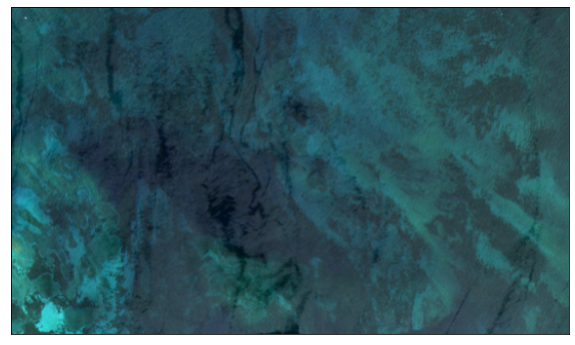

In [27]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=False
)
plt.show()

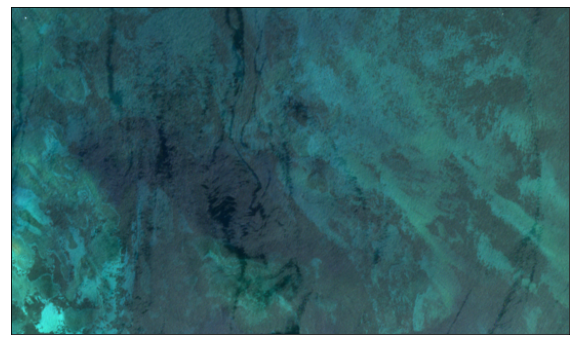

In [29]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2R_data"),
    stretch=False
)
plt.show()

In [8]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

X = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]

X.shape, y.shape

((138754, 1), (138754,))

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [10]:
score = reg.score(X, y)
score

0.7266961977398849

In [11]:
from sklearn.metrics import mean_absolute_error

ypred = reg.predict(X)
mean_absolute_error(y, ypred)

0.9154210285646736

In [12]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)

X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

y_hat_all = reg.predict(X_all)
estimated_bathymetry_stumpf_logratio = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
estimated_bathymetry_stumpf_logratio[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

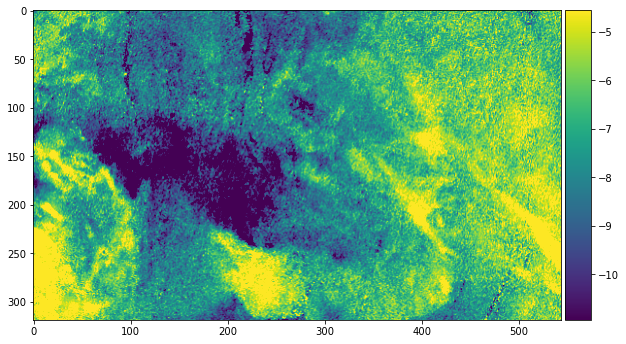

In [13]:
eolx.visualization.plot_ndarray_band(estimated_bathymetry_stumpf_logratio, cmap='viridis')
plt.show()

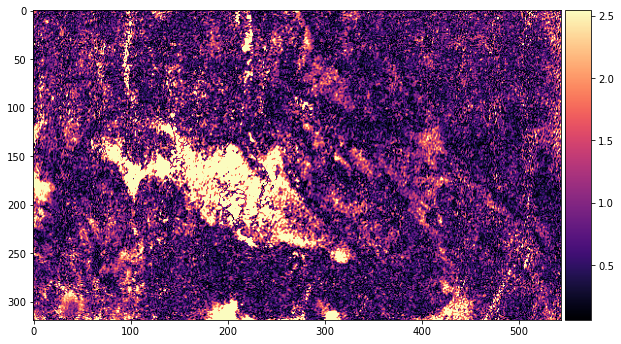

In [14]:
bathymetry_residuals_map = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')] - estimated_bathymetry_stumpf_logratio
eolx.visualization.plot_ndarray_band(np.abs(bathymetry_residuals_map), cmap='magma')
plt.show()

In [15]:
y_all = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1]
bathymetry_residuals = y_all - y_hat_all
bathymetry_residuals.shape

(173536,)

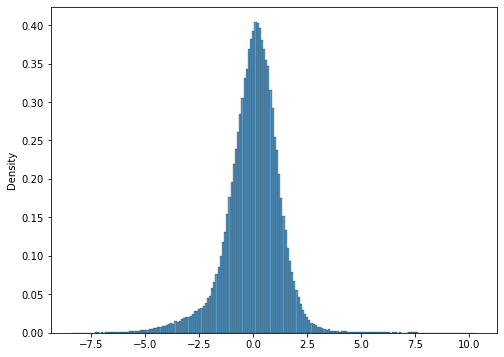

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(bathymetry_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

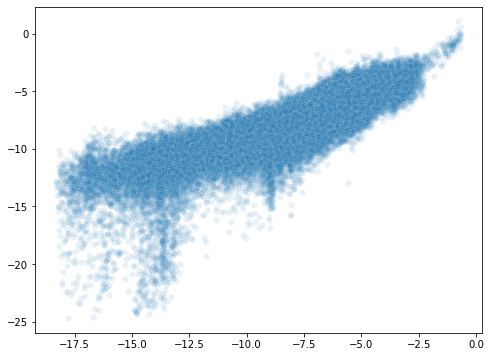

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=y_hat_all, alpha=0.1, ax=ax)
plt.show()

In [18]:
np.corrcoef(y_all, y_hat_all)

array([[1.        , 0.85277044],
       [0.85277044, 1.        ]])

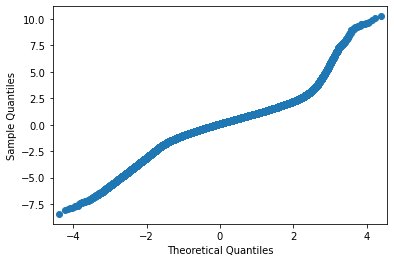

In [19]:
sm.qqplot(bathymetry_residuals)
plt.show()

## Acolite Example

In [30]:
X = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), train_mask_single_band)

y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((138754, 1), (138754,))

In [31]:
reg = LinearRegression()
reg.fit(X, y)

score = reg.score(X, y)
ypred = reg.predict(X)
mae = mean_absolute_error(y, ypred)

score, mae

(0.6761588989970202, 1.0073421)

In [33]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)

X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), mask_complete_single_band)

y_hat_all = reg.predict(X_all)
estimated_bathymetry_stumpf_logratio = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
estimated_bathymetry_stumpf_logratio[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

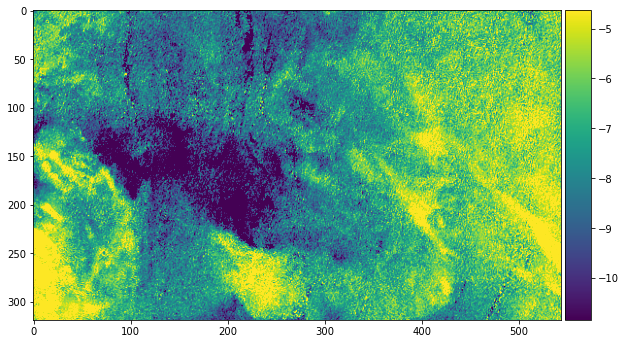

In [34]:
eolx.visualization.plot_ndarray_band(estimated_bathymetry_stumpf_logratio, cmap='viridis')
plt.show()

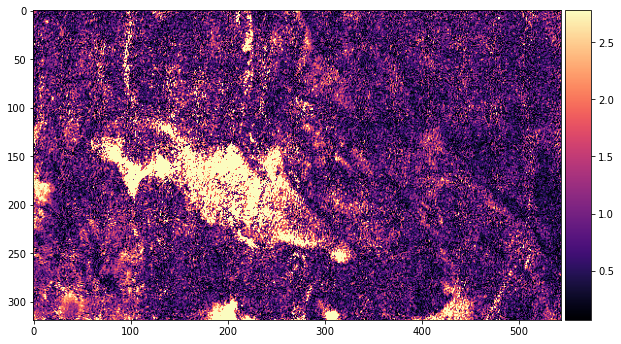

In [35]:
bathymetry_residuals_map = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')] - estimated_bathymetry_stumpf_logratio
eolx.visualization.plot_ndarray_band(np.abs(bathymetry_residuals_map), cmap='magma')
plt.show()

In [36]:
y_all = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1]
bathymetry_residuals = y_all - y_hat_all
bathymetry_residuals.shape

(173536,)

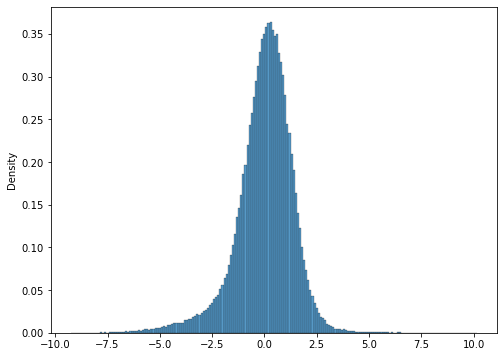

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(bathymetry_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

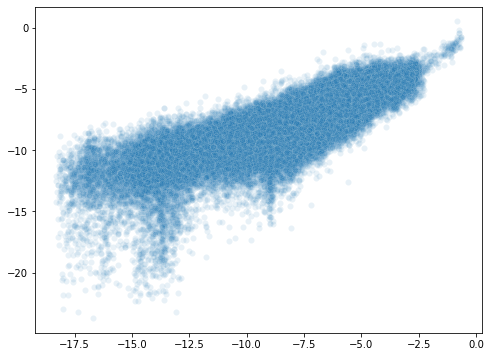

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=y_hat_all, alpha=0.1, ax=ax)
plt.show()

In [39]:
np.corrcoef(y_all, y_hat_all)

array([[1.        , 0.82257842],
       [0.82257842, 1.        ]])

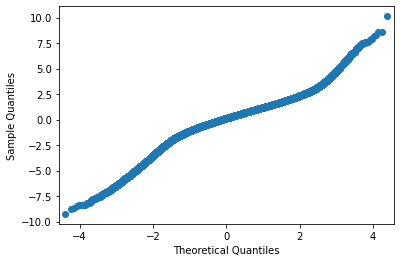

In [40]:
sm.qqplot(bathymetry_residuals)
plt.show()